# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [2]:
#Import the AG news dataset (same as hw01)
#Download them from here 
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

--2023-03-15 13:30:54--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M   110MB/s    in 0.3s    

2023-03-15 13:30:55 (110 MB/s) - ‘train.csv’ saved [29470338/29470338]



,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [3]:
##TODO pre-process text as you did in HW02
import spacy
dfs = df.sample(5000)
nlp = spacy.load('en_core_web_sm')

def tokenize(x):
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct]
dfs["preprocessed"] = dfs["text"].apply(lambda x: tokenize(x))

##TODO vectorize the pre-processed text using TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, 
                        max_df=0.9,  
                        max_features=1000,
                        stop_words='english',
                        use_idf=True, # the new piece
                        ngram_range=(1,2))

dfs["input_TFIDF"] = dfs["preprocessed"].apply(lambda x: " ".join(x))
X_tfidf = tfidf.fit_transform(dfs["input_TFIDF"])
X_tfidf.shape

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


(5000, 417)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=1000,
                        stop_words='english',
                        ngram_range=(1,3))
X_count = vec.fit_transform(dfs['input_TFIDF'])
X_count.shape

(5000, 431)

## Cosine Similarity and PCA

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

##TODO compute the cosine similarity for the first 200 snippets and for the first snippet, show the three most similar snippets and their respective cosine similarity scores

sim = cosine_similarity(X_tfidf[:200])
sim.shape

l = list(sim[0])
ids = []
while len(l) > 197:
    ids.append(int(l.pop(int(np.argmin(l)))))

dfs.iloc[ids]['input_TFIDF']

88341    horn honk caracas santana unanimous al cy youn...
88341    horn honk caracas santana unanimous al cy youn...
88341    horn honk caracas santana unanimous al cy youn...
Name: input_TFIDF, dtype: object

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the vectorized data using PCA

X_train_pca = pca.fit_transform(X_tfidf.toarray())

In [8]:
##TODO compute again cosine similarity with the reduced version for the first 200 snippets
sim = cosine_similarity(X_train_pca[:200])
sim.shape


##TODO for the first snippet, show again its three most similar snippets
l = list(sim[0])
ids = []
while len(l) > 197:
    ids.append(int(l.pop(int(np.argmin(l)))))

    dfs.iloc[ids]['input_TFIDF']

dfs.iloc[ids]['input_TFIDF']

88341    horn honk caracas santana unanimous al cy youn...
88341    horn honk caracas santana unanimous al cy youn...
88341    horn honk caracas santana unanimous al cy youn...
Name: input_TFIDF, dtype: object

Compare the cosine similarity before and after PCA reduction. Did the results change? 

## Clustering

In [9]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##TODO create the clusters found with k-medoids clustering nd 5 clusters

num_clusters = 40
km = KMedoids(n_clusters=5)
km.fit(X_tfidf)
doc_clusters = km.labels_.tolist()

dfs['cluster_medoids'] = doc_clusters

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.3 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(


In [ ]:
dfs['cluster_medoids'].value_counts()

0    4941
4      59
Name: cluster_medoids, dtype: int64

In [10]:
#!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##TODO create the clusters found with k-medoids clustering nd 5 clusters

num_clusters = 40
km = KMedoids(n_clusters=5)
km.fit(X_tfidf)
doc_clusters = km.labels_.tolist()

dfs['cluster_medoids'] = doc_clusters

##TODO create the clusters found with k-means clustering nd 5 clusters

num_clusters = 40
km = KMeans(n_clusters=5)
km.fit(X_tfidf)
doc_clusters = km.labels_.tolist()

dfs['cluster_means'] = doc_clusters

/usr/local/lib/python3.9/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


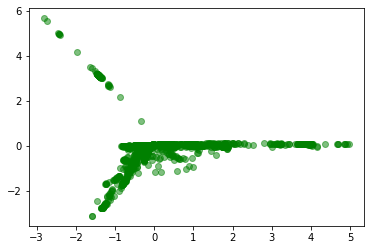

In [14]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
iso = Isomap(n_components=2)
med_iso = iso.fit_transform(X_tfidf)
plt.scatter(med_iso[dfs['cluster_medoids']==0,0], med_iso[dfs['cluster_medoids']==0,1], color='green', alpha=0.5)
plt.scatter(med_iso[dfs['cluster_medoids']==1,0], med_iso[dfs['cluster_medoids']==1,1], color='blue', alpha=0.5)
plt.scatter(med_iso[dfs['cluster_medoids']==2,0], med_iso[dfs['cluster_medoids']==2,1], color='red', alpha=0.5)
plt.scatter(med_iso[dfs['cluster_medoids']==3,0], med_iso[dfs['cluster_medoids']==3,1], color='yellow', alpha=0.5)
plt.scatter(med_iso[dfs['cluster_medoids']==4,0], med_iso[dfs['cluster_medoids']==4,1], color='black', alpha=0.5)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


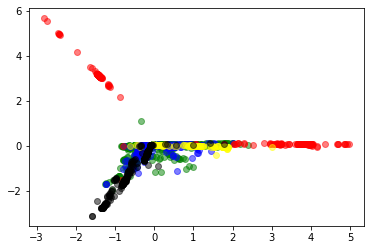

In [15]:
##TODO similarly, visualize the k-means results
iso = Isomap(n_components=2)
mean_iso = iso.fit_transform(X_tfidf)
plt.scatter(mean_iso[dfs['cluster_means']==0,0], mean_iso[dfs['cluster_means']==0,1], color='green', alpha=0.5)
plt.scatter(mean_iso[dfs['cluster_means']==1,0], mean_iso[dfs['cluster_means']==1,1], color='blue', alpha=0.5)
plt.scatter(mean_iso[dfs['cluster_means']==2,0], mean_iso[dfs['cluster_means']==2,1], color='red', alpha=0.5)
plt.scatter(mean_iso[dfs['cluster_means']==3,0], mean_iso[dfs['cluster_means']==3,1], color='yellow', alpha=0.5)
plt.scatter(mean_iso[dfs['cluster_means']==4,0], mean_iso[dfs['cluster_means']==4,1], color='black', alpha=0.5)

## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [ ]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies

dictionary = Dictionary(dfs["preprocessed"])
dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)
print (len(dictionary))
##TODO create the doc_term_matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dfs["preprocessed"]]


KeyError: ignored

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics
##TODO compute the coherence score for each of these model and print the topics from the model with highest coherence score. Then find the opitimal number of topics using the coherence score.
mallet_path = 'mallet-2.0.0/bin/mallet'
scores = []
for num_topics in [5, 10, 15]:
    lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=lda, texts=dfs['tokens'], corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v')
    scores.append((num_topics, coherence.get_coherence()))

df_topic = pd.DataFrame(scores, columns=["Number of Topics", "Coherence Scores"])
df_topic.head()

NameError: ignored

In [ ]:
#!pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import wrappers
##TODO using LDAvis visualize the topics using the optimal number of topics
lda = LdaMallet(mallet_path, doc_Term_matrix, num_topics=opt_topics, id2word=dictionary)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_vis, doc_term_matrix, dictionary)